# Importing Libraries and Opening the Files

In [1]:
import segyio
import matplotlib.pyplot as plt
import numpy as np
from shutil import copyfile
import pandas as pd
%matplotlib inline

In [5]:
filename = 'C:/Users/karth/Desktop/Research Literature/ST10010ZC11_PZ_PSDM_KIRCH_FAR_D.MIG_FIN.POST_STACK.3D.JS-017536.segy'
filename1 = 'C:/Users/karth/Desktop/Research Literature/Dutch Government_F3_entire_8bit seismic.segy'

# Code to Store Traces in a DataFrame

In [3]:
## Function to store traces in a dataframe

def parse_trace_headers(segyfile, n_traces):
    '''
    Parse the segy file trace headers into a pandas dataframe.
    Column names are defined from segyio internal tracefield
    One row per trace
    '''
    # Get all header keys
    headers = segyio.tracefield.keys
    # Initialize dataframe with trace id as index and headers as columns
    df = pd.DataFrame(index=range(1, n_traces + 1),
                      columns=headers.keys())
    # Fill dataframe with all header values
    for k, v in headers.items():
        df[k] = segyfile.attributes(v)[:]
    return df

In [20]:
## Code to stores traces in a dataframe.

with segyio.open(filename, ignore_geometry=True) as f:    ## Ignoring Geometery due to inconsistent inline , xline.
    n_traces = f.tracecount
    trace_headers = parse_trace_headers(f,n_traces)
    h = f.text[0]
    h = h.decode('ascii')
    print(h)

C01 CLIENT : STATOIL                              PROCESSED BY: WESTERNGECO     C02 AREA   : VOLVE, BLOCK 15/9,  NORTH SEA - ST10010     SURVEY: 3D 4C 0BC      C03 3D FULL AREA POST-STACK FINAL PSDM                       DATE: 2011-10-26   C04 DATA FORMAT: SEGY       DATA TYPE: STACK-FAR ANGLE, 32.34-41 DEGREES (D)    C05 ---------------------AQUISITION PARAMETRS---------------------------------- C06 DATA SHOT BY VESSEL: M/V SANCO SPIRIT & VIKLAND  CABLE LENGTH:6000 M        C07 NO OF GROUPS: 960/P,X,Y,Z.  NO OF CABLES: 8  ARRAY VOL/SOURCE: 3990 CU IN.  C08 GROUP INTERVAL: 25M  SHOT INTERVAL: 25M (FLIP-FLOP)  RECORD LENGTH: 10000 MSC09 GEODECTIC DATUM:  ED50      SPHEROID: INTERNAT 1924     PROJECTION: UTM     C10  UTM ZONE: 31 N                                                             C11 FIRST SAMPLE: 4 M     LAST SAMPLE: 4500 M     SAMPLE INTERVAL: 4 M          C12 NAVIGATION SOURCE P1/90 UKOOA, SPS                                          C13 ----------------------PROCESSING SEQ

# Coordinate Calculation Code

In [5]:
## Functions to calculate coordinates of a specific inline and crossline.

def dvt_constin(inline_no):
    cl_dy = trace_headers[trace_headers['INLINE_3D'] == inline_no][['CDP_Y']]/100
    cl_dx = trace_headers[trace_headers['INLINE_3D'] == inline_no][['CDP_X']]/100
    
    c_dy = cl_dy.to_numpy()
    c_dx = cl_dx.to_numpy()
    
    ## Calculating Difference in value.
    dy_cross = np.mean(np.diff(c_dy,axis = 0))
    dx_cross = np.mean(np.diff(c_dx,axis = 0))
    
    return(dy_cross,dx_cross)

def dvt_constcl(crossline_no):
    il_dy = trace_headers[trace_headers['INLINE_3D'] == crossline_no][['CDP_Y']]/100
    il_dx = trace_headers[trace_headers['INLINE_3D'] == crossline_no][['CDP_X']]/100
    
    c_dy = il_dy.to_numpy()
    c_dx = il_dx.to_numpy()
    
    ## Calculating Difference in value.
    dy_in = np.mean(np.diff(c_dy,axis = 0))
    dx_in = np.mean(np.diff(c_dx,axis = 0))
    
    return(dy_in,dx_in)


def coord_pred(inline_no , crossline_no):
    x_actual = 0
    y_actual = 0
    if ((trace_headers[(trace_headers['INLINE_3D'] == inline_no) & (trace_headers['CROSSLINE_3D'] == crossline_no)][['CDP_X','CDP_Y']]).empty):
        ## Logic implemented here.
        flag = 1
        #maxi = 
        x = crossline_no
        ## Logic for if statement.
        maxi = (trace_headers[(trace_headers['INLINE_3D'] == inline_no)][['CROSSLINE_3D']])
        maxi = np.max(maxi)
        maxi = maxi.to_numpy()
        if ( x > maxi[0] ):
            flag = -1
        else :
            flag  = 1
        x = x + flag
        while(1):
            if ((trace_headers[(trace_headers['INLINE_3D'] == inline_no) & (trace_headers['CROSSLINE_3D'] == x)][['CDP_X','CDP_Y']]).empty):
                x = x + flag
                continue
            else :
                (dy_cross , dx_cross) = dvt_constin(inline_no)
                (dy_in , dx_in ) = dvt_constcl(x)
                
                x_actual = dx_cross*(crossline_no-x) + (trace_headers[(trace_headers['INLINE_3D'] == inline_no) & (trace_headers['CROSSLINE_3D'] == x)][['CDP_X']])/100
                y_actual = dy_cross*(crossline_no-x) + (trace_headers[(trace_headers['INLINE_3D'] == inline_no) & (trace_headers['CROSSLINE_3D'] == x)][['CDP_Y']])/100
                break
                
        return (x_actual,y_actual)
    
    else:
        x_actual = trace_headers[(trace_headers['INLINE_3D'] == inline_no) & (trace_headers['CROSSLINE_3D'] == crossline_no)][['CDP_X']]/100
        y_actual = trace_headers[(trace_headers['INLINE_3D'] == inline_no) & (trace_headers['CROSSLINE_3D'] == crossline_no)][['CDP_Y']]/100
        return(x_actual,y_actual)

# User Input Side

In [6]:
## User input code.

inline_no = 9961
crossline_no = 1881

x,y = coord_pred(inline_no,crossline_no)
x = x.to_numpy()
y = y.to_numpy()
print(x[0][0])
print(y[0][0])

439272.9474581005
6475068.806648045


C:\Users\karth\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\karth\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


# Converting Cooridnates

In [21]:
from pyproj import Proj, Transformer, CRS

In [34]:
## Alternate code for general parsing.

import re

text = h

m = re.search('(.+?)END', h)
if m:
    found = m.group(1)
    
txt = found.split()

pos = 0
flag = 0

if any("UTM" in s for s in txt):
    flag = 1
else :
    flag = 0
    
    
if ( flag == 1):
    while(pos < len(txt)):
        if ( txt[pos] == 'ZONE:'):
            if ( txt[pos-1] == 'UTM'):
                no = txt[pos+1]
                direc = txt[pos+2]
            else :
                continue
        pos = pos + 1

else:
    print("No coordinate system found!!")


In [36]:
if(direc == 'N'):
    bl = False
else:
    bl = True
    
crs = CRS.from_dict({'proj': 'utm', 'zone': no, 'south': bl})
f_str = (crs.to_authority())  # ('EPSG', '32736')

print(f_str)    ## String With coordinate system values for current segy file i.e epsg number

('EPSG', '32631')


In [8]:
## Code to obtain epsg numbers.
'''
import re

text = h

m = re.search('C10(.+?)C11', h)
if m:
    found = m.group(1)

st = found.split()

## Code to check coordinate system.
zone_no = st[2]
flag = False
if(st[3] == 'N'):
    flag = False
else:
    flag = True
crs = CRS.from_string('+proj=utm +zone=36 +south')
# or dictionary
crs = CRS.from_dict({'proj': 'utm', 'zone': zone_no, 'south': flag})

f_str = (crs.to_authority())  # ('EPSG', '32736')

print(f_str)
'''

('EPSG', '32631')


In [37]:
## Code After Parsing through the text header

x = trace_headers['CDP_X']/100
y = trace_headers['CDP_Y']/100

x1 = np.array(x)
y1 = np.array(y)

st1 = "epsg:"
st2 = f_str[1]   ## String With epsg Number.

st1 = st1 + st2   ## Concatenating the two strings.

p1 = Proj(st1)
lon , lat = p1(x1,y1,inverse=True)

In [38]:
p1 = Proj(st1)
trace_headers['lat'] = pd.Series(lat, index=trace_headers.index)
trace_headers['lon'] = pd.Series(lon, index=trace_headers.index)

In [39]:
trace_headers.head()  ## Data Frame head with lat and long.

,TRACE_SEQUENCE_LINE,TRACE_SEQUENCE_FILE,FieldRecord,TraceNumber,EnergySourcePoint,CDP,CDP_TRACE,TraceIdentificationCode,NSummedTraces,NStackedTraces,...,SourceType,SourceEnergyDirectionMantissa,SourceEnergyDirectionExponent,SourceMeasurementMantissa,SourceMeasurementExponent,SourceMeasurementUnit,UnassignedInt1,UnassignedInt2,lat,lon
1,1,1,3,1,1963,83,1,1,1,3,...,0,0,83,0,0,0,0,0,58.414256,1.943549
2,2,2,4,1,1964,84,2,1,1,2,...,0,0,84,0,0,0,0,0,58.414281,1.943341
3,3,3,5,1,1965,85,3,1,1,2,...,0,0,85,0,0,0,0,0,58.414307,1.943132
4,4,4,6,1,1966,86,4,1,1,1,...,0,0,86,0,0,0,0,0,58.414332,1.942924
5,5,5,7,1,1967,87,5,1,1,4,...,0,0,87,0,0,0,0,0,58.414358,1.942716


# Plotting Latitude and Longitude

In [40]:
Bbox = (trace_headers.lon.min(), trace_headers.lon.max(),trace_headers.lat.min(), trace_headers.lat.max())
Bbox 

(1.7941668212069157, 1.963389321130547, 58.414255969625756, 58.476173248464676)

In [45]:
file_loc = 'C:/Users/karth/Downloads/map.png'   ## File to be downloaded from internet. Use Bounding Box to extract image.

In [42]:
ruh_m = plt.imread(file_loc)

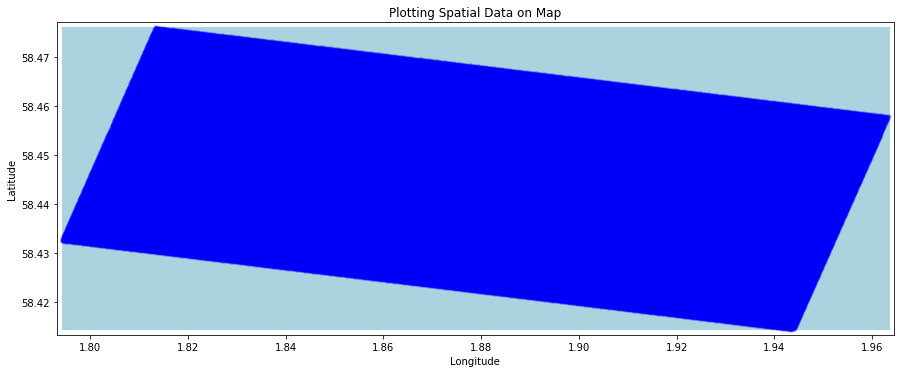

In [47]:
fig, ax = plt.subplots(figsize = (15,10))
ax.scatter(trace_headers.lon, trace_headers.lat, zorder=1, alpha= 0.2, c='b', s=10 ,cmap = 'jet_r')
ax.set_title('Plotting Spatial Data on Map')
ax.set_xlim(Bbox[0]-0.001,Bbox[1]+0.001)
ax.set_ylim(Bbox[2]-0.001,Bbox[3]+0.001)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.imshow(ruh_m, zorder=0,extent = Bbox ,aspect= 'equal')